In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 9.9 MB/s 
     |████████████████████████████████| 209 kB 51.8 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 112 kB 57.7 MB/s 
     |████████████████████████████████| 146 kB 60.0 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1a7d3443b862093b037f8f1252e644160cf092c8da6e1cf926a27ff9f43130a8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import joblib
import pickle
import optuna

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_key_v2.pickle', 'rb') as f:
    data = pickle.load(f)


data = data[['date', 'trade_price']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values(by='date').reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['trade_price']

# 예측 데이터 사이즈
max_prediction_length = 20

# 학습용 데이터
data_p = data.iloc[:data.index.max() - max_prediction_length +1, :]
training_data = scaler.fit_transform(data_p[scale_cols])

# max_prediction_length 만큼의 데이터는 예측 데이터와 비교를 위해 분리
actual_data = data.loc[~data.index.isin(data_p.index)][scale_cols]




In [ ]:
def sliding_windows(data, lookback_length, forecast_length):

    x = []
    y = []
    
    for i in range(lookback_length, len(data) - forecast_length + 1):
        _x = data[(i-lookback_length) : i]
        _y = data[i : (i + forecast_length)]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)


def get_data_loader(X, y, batch_size):

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    train_ds = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    train_dl = DataLoader(train_ds, batch_size = batch_size)

    val_ds = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
    val_dl = DataLoader(val_ds, batch_size = batch_size)

    input_size = x_train.shape[-1]

    return train_dl, val_dl, input_size

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size , num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
def train(log_interval, model, train_dl, val_dl, optimizer, criterion, epoch):

    best_loss = np.inf
    for epoch in range(epoch):
        train_loss = 0.0
        model.train()
        for data, target in train_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                model = model.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) # mean-squared error for regression
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation
        valid_loss = 0.0
        model.eval()
        for data, target in val_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            output = model(data)         
            loss = criterion(output, target)
            valid_loss += loss.item()

        if ( epoch % log_interval == 0 ):
            print(f'\n Epoch {epoch} \t Training Loss: {train_loss / len(train_dl)} \t Validation Loss: {valid_loss / len(val_dl)} \n')

        if best_loss > (valid_loss / len(val_dl)):
            print(f'Validation Loss Decreased({best_loss:.6f}--->{(valid_loss / len(val_dl)):.6f}) \t Saving The Model')
            best_loss = (valid_loss / len(val_dl))
            torch.save(model.state_dict(), 'lstm_saved_model.pth')

    return best_loss


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [ ]:
def objective(trial):

    cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
            'batch_size' : trial.suggest_categorical('batch_size',[64, 128, 256]), # [64, 128, 256]
            'num_epochs' : trial.suggest_int('num_epochs', 20, 20), #1000, 1600, 100), 
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), #trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), # learning rate을 0.01-0.1까지 로그 uniform 분포로 사용          
            'momentum': trial.suggest_uniform('momentum', 0.4, 0.99),
            'optimizer': trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam]), # trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam]),
            # 'activation': trial.suggest_categorical('activation',[ torch.nn.relu6, torch.nn.tanh ]),
            'hidden_size': trial.suggest_categorical('hidden_size',[64, 128, 256]),
            'num_layers': trial.suggest_int('num_layers', 1, 1),
            'num_classes': trial.suggest_int('num_classes', 1, 1) }

    torch.manual_seed(42)

    lookback_length = 60
    forecast_length = 1
    log_interval = 100

    x, y = sliding_windows(training_data, lookback_length, forecast_length)

    train_dl, val_dl, input_size = get_data_loader(x, y,  cfg['batch_size'])
    model = LSTM(num_classes=cfg['num_classes'], input_size=input_size, hidden_size=cfg['hidden_size'], num_layers=cfg['num_layers'])
    optimizer = cfg['optimizer'](model.parameters(), lr=cfg['learning_rate'])
    criterion = torch.nn.MSELoss()

    # if torch.cuda.is_available():
    #     model = model.cuda()

    best_loss = train(log_interval, model, train_dl, val_dl, optimizer, criterion, cfg['num_epochs'])

    predict_data = []

    x_pred = x[-1:, :, :]  # last observed input sequence
    y_pred = y[-1]         # last observed target value

    for i in range(max_prediction_length):

        # feed the last forecast back to the model as an input
        x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

        xt_pred = torch.Tensor(x_pred)

        # generate the next forecast
        yt_pred = model(xt_pred)

        # tensor to array
        x_pred = xt_pred.detach().numpy()
        y_pred = yt_pred.detach().numpy()

        # save the forecast
        predict_data.append(y_pred.flatten()[0])

    # transform the forecasts back to the original scale
    predict_data = np.array(predict_data).reshape(-1, 1)
    predict = scaler.inverse_transform(predict_data)

    actual = np.array(actual_data)

    SMAPE = smape(actual, predict)
    print(f' \nSMAPE : {SMAPE}')


    return SMAPE


In [ ]:
sampler = optuna.samplers.TPESampler()
#   sampler = optuna.samplers.SkoptSampler()

# model.load_state_dict(torch.load('lstm_saved_model.pth'))
    
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=2)

[I 2022-06-12 03:47:57,962] A new study created in memory with name: no-name-64df0134-5687-4810-a984-9debbf65a4fb



 Epoch 0 	 Training Loss: 0.031951270896983755 	 Validation Loss: 0.2751297156016032 

Validation Loss Decreased(inf--->0.275130) 	 Saving The Model
Validation Loss Decreased(0.275130--->0.252326) 	 Saving The Model
Validation Loss Decreased(0.252326--->0.244799) 	 Saving The Model
Validation Loss Decreased(0.244799--->0.241057) 	 Saving The Model
Validation Loss Decreased(0.241057--->0.238276) 	 Saving The Model
Validation Loss Decreased(0.238276--->0.235739) 	 Saving The Model
Validation Loss Decreased(0.235739--->0.233263) 	 Saving The Model
Validation Loss Decreased(0.233263--->0.230798) 	 Saving The Model
Validation Loss Decreased(0.230798--->0.228331) 	 Saving The Model
Validation Loss Decreased(0.228331--->0.225857) 	 Saving The Model
Validation Loss Decreased(0.225857--->0.223373) 	 Saving The Model
Validation Loss Decreased(0.223373--->0.220878) 	 Saving The Model
Validation Loss Decreased(0.220878--->0.218371) 	 Saving The Model
Validation Loss Decreased(0.218371--->0.215850

[I 2022-06-12 03:48:06,453] Trial 0 finished with value: 78.1191539386772 and parameters: {'batch_size': 128, 'num_epochs': 20, 'learning_rate': 0.04190891087524368, 'momentum': 0.9523669944633723, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 64, 'num_layers': 1, 'num_classes': 1}. Best is trial 0 with value: 78.1191539386772.


Validation Loss Decreased(0.202996--->0.200368) 	 Saving The Model
 
SMAPE : 78.1191539386772

 Epoch 0 	 Training Loss: 0.1732675573633363 	 Validation Loss: 0.2798471301794052 

Validation Loss Decreased(inf--->0.279847) 	 Saving The Model
Validation Loss Decreased(0.279847--->0.152892) 	 Saving The Model
Validation Loss Decreased(0.152892--->0.132124) 	 Saving The Model
Validation Loss Decreased(0.132124--->0.092147) 	 Saving The Model
Validation Loss Decreased(0.092147--->0.046536) 	 Saving The Model
Validation Loss Decreased(0.046536--->0.028491) 	 Saving The Model
Validation Loss Decreased(0.028491--->0.027692) 	 Saving The Model


[I 2022-06-12 03:48:13,852] Trial 1 finished with value: 26.231327061875977 and parameters: {'batch_size': 256, 'num_epochs': 20, 'learning_rate': 0.04099437464932105, 'momentum': 0.7716778345777988, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 64, 'num_layers': 1, 'num_classes': 1}. Best is trial 1 with value: 26.231327061875977.


 
SMAPE : 26.231327061875977


In [ ]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna_220612_01.pkl')
joblib.dump(study, '/content/lstm_optuna.pkl')

['/content/lstm_optuna.pkl']

Number of finished trials:  2
Best trial:
  Value:  26.231327061875977
  Params: 
    batch_size: 256
    num_epochs: 20
    learning_rate: 0.04099437464932105
    momentum: 0.7716778345777988
    optimizer: <class 'torch.optim.adam.Adam'>
    hidden_size: 64
    num_layers: 1
    num_classes: 1


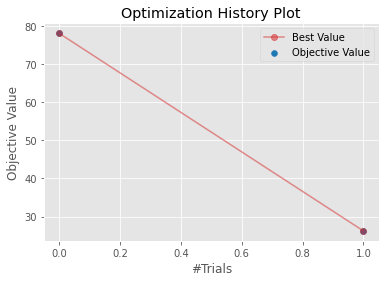

In [ ]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.show()


optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

## Plot Results


 Epoch 0 	 Training Loss: 0.1732675573633363 	 Validation Loss: 0.2798471301794052 

Validation Loss Decreased(inf--->0.279847) 	 Saving The Model
Validation Loss Decreased(0.279847--->0.152892) 	 Saving The Model
Validation Loss Decreased(0.152892--->0.132124) 	 Saving The Model
Validation Loss Decreased(0.132124--->0.092147) 	 Saving The Model
Validation Loss Decreased(0.092147--->0.046536) 	 Saving The Model
Validation Loss Decreased(0.046536--->0.028491) 	 Saving The Model
Validation Loss Decreased(0.028491--->0.027692) 	 Saving The Model
 
SMAPE : 26.231327061875977


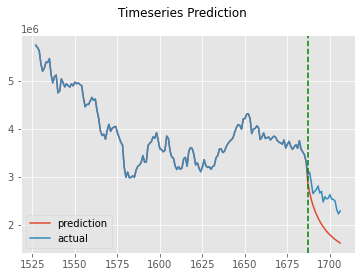

In [ ]:
torch.manual_seed(42)

lookback_length = 60
forecast_length = 1
log_interval = 100

x, y = sliding_windows(training_data, lookback_length, forecast_length)

train_dl, val_dl, input_size = get_data_loader(x, y,  study.best_params['batch_size'])
best_model = LSTM(num_classes=study.best_params['num_classes'], input_size=input_size, hidden_size=study.best_params['hidden_size'], num_layers=study.best_params['num_layers'])
optimizer = study.best_params['optimizer'](best_model.parameters(), lr=study.best_params['learning_rate'])
criterion = torch.nn.MSELoss()

best_loss = train(log_interval, best_model, train_dl, val_dl, optimizer, criterion, study.best_params['num_epochs'])

predict_data = []

x_pred = x[-1:, :, :]  # last observed input sequence
y_pred = y[-1]         # last observed target value

for i in range(max_prediction_length):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

    xt_pred = torch.Tensor(x_pred)

    # generate the next forecast
    yt_pred = best_model(xt_pred)

    # tensor to array
    x_pred = xt_pred.detach().numpy()
    y_pred = yt_pred.detach().numpy()

    # save the forecast
    predict_data.append(y_pred.flatten()[0])

# transform the forecasts back to the original scale
predict_data = np.array(predict_data).reshape(-1, 1)
predict = scaler.inverse_transform(predict_data)

actual = np.array(actual_data)

SMAPE = smape(actual, predict)
print(f' \nSMAPE : {SMAPE}')

# torch.save(best_model.state_dict(), "lstm.pt")


pred_df = pd.concat([data_p[scale_cols], pd.DataFrame(predict, columns=['trade_price'])], axis=0).reset_index(drop=True)
pred_df = pred_df.rename(columns = {'trade_price':'pred_price'})
data_df = pd.concat([data, pred_df], axis=1)

plt.plot(data_df['pred_price'][len(data_df)-lookback_length*3:], label='prediction')
plt.plot(data_df['trade_price'][len(data_df)-lookback_length*3:], label='actual')
plt.suptitle('Timeseries Prediction')
plt.suptitle('Timeseries Prediction')
plt.axvline(x = len(data_df) - len(predict), c = 'g', linestyle = '--')
plt.legend()
plt.show();


ZeroDivisionError: ignored

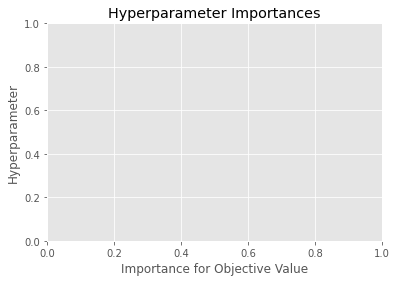

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()
# df_plot = df_plot[df_plot['value']!=0]